Import libraries and read the input data.

In [1]:
from ert_pygimli_functions import *
from res2dinv_converter import *

df = pd.read_excel('24IRCH_Modeling.xlsx')

WennerSchlum = pd.read_table('WennerSchlum.txt')
exportFile(WennerSchlum, 2.5, 'Array.ohm')


Run a loop that calculates a forward model (Wenner-Schlumberger) for each given gemetries and inverts the sythetic data to retrieve the resistivity distribution of the subsurface.

In [3]:
i = 0

for column_name, item in df.items():

    # Skip the first column (contains indications, not actual geometries)
    if i == 0:
        i += 1
        continue
    
    # Implement the geometry by parsing the table
    rhomap, geom = implement_geometry(df.iloc[: ,i])

    # Implement the model ID
    model_id = column_name

    # Calulate the min and max resistivity values
    rho_min = df.iloc[2:5, i].min()
    rho_max = df.iloc[2:5, i].max()

    # Generate a scheme (from the Wenner Schlumberger array text file)
    scheme = pg.load('Array.ohm', verbose=True, testAll=False, realName=None)

    # Create the mesh on which the data will be generated
    mesh = create_mesh(scheme, geom, rhomap, quality = 30)

    # Generate the synthetic data
    data = generate_data(mesh, scheme, rhomap)

    # Save the data
    filename = 'data_synth/ert_' + str(model_id) + '.dat'
    save_data(data, filename)

    # Save the res2dinv file
    filename_res2dinv = 'data_res2dinv/ert_' + str(model_id) + '.dat'
    exporting_data = read_data_gimli(filename)
    convert_2_res2dinv(exporting_data, filename_res2dinv)

    # Initialize GIMLI manager
    manager = initialize_ERTMANAGER(path=f'data_synth/ert_{model_id}.dat')

    # mesh_inv = mt.createMesh(quality=25)
    inv = invert_data(data, mesh, manager)
    meshPD = generate_meshPD(manager)

    # Visualize the inversion
    visualize_inversion(model_id, data, manager, mesh, rhomap, 1e1, 1e3)

    i+=1

Function to import data from res2Dinv inversions. Plots these results with the same colormap as the inversion processed by GIMLI.

Skipping line due to error: could not convert string to float: '/'


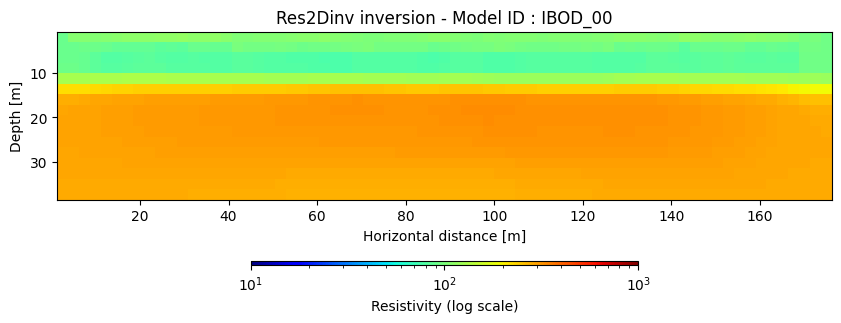

Skipping line due to error: could not convert string to float: '/'


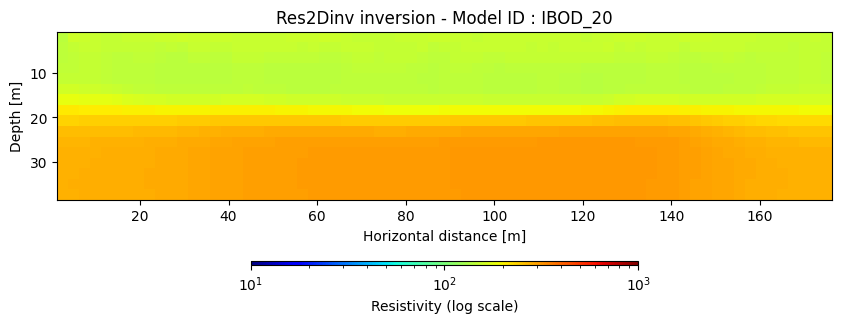

Skipping line due to error: could not convert string to float: '/'


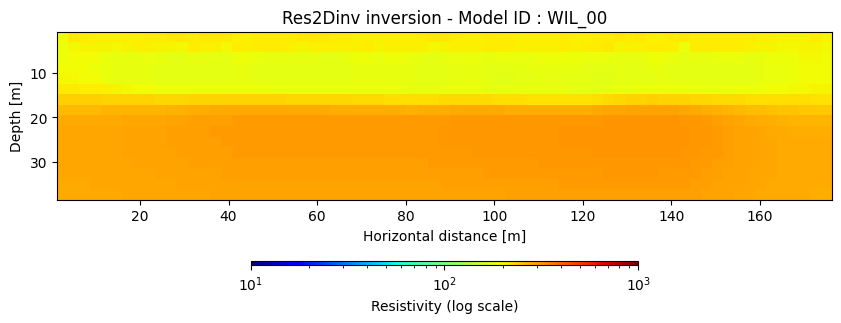

Skipping line due to error: could not convert string to float: '/'


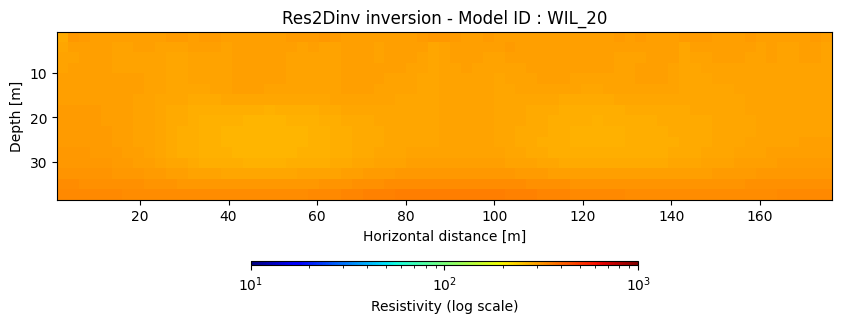

Skipping line due to error: could not convert string to float: '/'


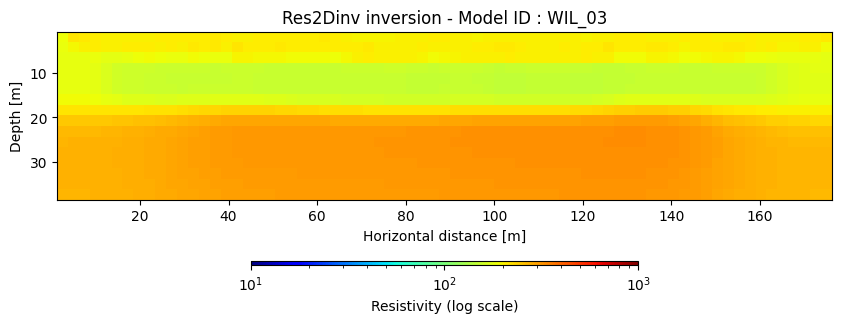

In [ ]:

def read_and_plot_resistivity_colormap(filepath, start_line=2474, end_line=3610):
    # Read the data from the specified lines
    with open(filepath, 'r') as file:
        lines = file.readlines()[start_line-1:end_line]

    directory = os.path.dirname(filepath)
    model_id = os.path.basename(directory)


    # Extract relevant data
    data = []
    for line in lines:
        parts = line.split()
        if len(parts) >= 6:  # Ensure the line has enough parts
            try:
                x, depth, resistivity = float(parts[0]), float(parts[1]), float(parts[2])
                data.append((x, depth, resistivity))
            except ValueError as e:
                print(f"Skipping line due to error: {e}")
                continue

    # Check if data was extracted
    if not data:
        print("No valid data found. Please check the input file and line numbers.")
        return
    
    # Convert data to a DataFrame
    df = pd.DataFrame(data, columns=['X', 'Depth', 'Resistivity'])
    
    # Check if DataFrame is empty
    if df.empty:
        print("DataFrame is empty. No data to plot.")
        return
    
    # Pivot the DataFrame to create a grid of resistivity values
    pivot_df = df.pivot(index='Depth', columns='X', values='Resistivity')

    # Plot the colormap using the 'jet' cmap with logarithmic color scale
    plt.figure(figsize=(10, 8))
    plt.imshow(pivot_df, cmap='jet', origin='lower',
               extent=(df['X'].min(), df['X'].max(), df['Depth'].min(), df['Depth'].max()),
               norm=LogNorm(vmin=1e1, vmax=1e3))
    cbar = plt.colorbar(label='Resistivity [\Omega m]', pad=0.1, shrink=.5, aspect=100, orientation='horizontal')
    cbar.set_label('Resistivity (log scale)')
    plt.title('Res2Dinv inversion - Model ID : '+model_id)
    plt.xlabel('Horizontal distance [m]')
    plt.ylabel('Depth [m]')
    plt.gca().invert_yaxis()
    plt.show()

    plt.savefig(f'{directory}/resistivity_JET_colormap_'+model_id+'.png')
    plt.close()

# Example usage
folder_path = '/Users/bart/Documents/Indépendant/Geophy/InversionLori/'
models = ['IBOD_00/ert_IBOD_00.xyz', 'IBOD_20/ert_IBOD_20.xyz', 'WIL_00/ert_WIL_00.xyz', 'WIL_20/ert_WIL_20.xyz', 'WIL_03/ert_WIL_03.xyz']
# file_path = '/Users/bart/Documents/Indépendant/Geophy/InversionLori/IBOD_00/ert_IBOD_00.xyz'

for model in models:
    file_path = folder_path + model
    read_and_plot_resistivity_colormap(file_path)
